<a href="https://colab.research.google.com/github/francoisdoanp/MLTBP/blob/master/Project_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine learning - Final Project**

# Turbofan engine degradation dataset (NASA)

# Data Preparation

**Importing necessary packages**



In [0]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Importing the Turbofan engine degradation dataset.**

**Files are located in the following Github repository: https://github.com/francoisdoanp/MLTBP**

We have 4 training datasets, which contains information about one hundred engines, all of the same type. Thus, we will combine the training and test data sets. 

The training and test sets have 21 columns: ID, Time (Cycles), 3 columns for operational settings and 21 sensor measurements.

The training and testing sets have the same format, while the validation sets only contain the real RUL (remaining useful life).

For more information on the data, consult the read me at the following address:https://github.com/francoisdoanp/MLTBP/blob/master/readme.txt

In [0]:
url_base = 'https://raw.githubusercontent.com/francoisdoanp/MLTBP/master/'

file_train_1 = 'train_FD001.txt'
file_train_2 = 'train_FD002.txt'
file_train_3 = 'train_FD003.txt'
file_train_4 = 'train_FD004.txt'

file_test_1 = 'test_FD001.txt'
file_test_2 = 'test_FD002.txt'
file_test_3 = 'test_FD003.txt'
file_test_4 = 'test_FD004.txt'

file_valid_1 = 'RUL_FD001.txt'
file_valid_2 = 'RUL_FD002.txt'
file_valid_3 = 'RUL_FD003.txt'
file_valid_4 = 'RUL_FD004.txt'


pt1 = pd.read_csv(url_base + file_train_1, sep=' ', header=None)
pt2 = pd.read_csv(url_base + file_train_2, sep=' ', header=None)
pt3 = pd.read_csv(url_base + file_train_3, sep=' ', header=None)
pt4 = pd.read_csv(url_base + file_train_4, sep=' ', header=None)

pte1 = pd.read_csv(url_base + file_test_1, sep=' ', header=None)
pte2 = pd.read_csv(url_base + file_test_2, sep=' ', header=None)
pte3 = pd.read_csv(url_base + file_test_3, sep=' ', header=None)
pte4 = pd.read_csv(url_base + file_test_4, sep=' ', header=None)

pv1 = pd.read_csv(url_base + file_valid_1, header=None)
pv2 = pd.read_csv(url_base + file_valid_2, header=None)
pv3 = pd.read_csv(url_base + file_valid_3, header=None)
pv4 = pd.read_csv(url_base + file_valid_4, header=None)


# Updating unit numbers

pt2[0] = pt2[0].apply(lambda x: x+100)
pt3[0] = pt3[0].apply(lambda x: x+360)
pt4[0] = pt4[0].apply(lambda x: x+460)

pte2[0] = pte2[0].apply(lambda x: x+100)
pte3[0] = pte3[0].apply(lambda x: x+359)
pte4[0] = pte4[0].apply(lambda x: x+459)


# Joining the dataframes

train_pd = pd.concat([pt1,pt2,pt3,pt4])
test_pd = pd.concat([pte1,pte2,pte3,pte4])
valid_pd = pd.concat([pv1,pv2,pv3,pv4])

train_pd = train_pd.drop(train_pd.columns[[26,27]], axis='columns')
test_pd = test_pd.drop(test_pd.columns[[26,27]], axis='columns')


# Assigning labels to Dataframe's columns based on the Readme

train_pd.columns = ['Unit Number', 'Time (Cycles)', 'OS1', 'OS2', 'OS3', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21']
test_pd.columns = ['Unit Number', 'Time (Cycles)', 'OS1', 'OS2', 'OS3', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21']
valid_pd.columns = ['RUL']

  

**Adding variables Conditons and fault mode**

Note:

**Condition (ONE)** and **Fault ONE** are binary variables.

When Condition(ONE) = 1 (true), it means that the condition is at Sea Level

When Condition(ONE) = 0 (false), it means NO, the condition IS NOT AT SEA LEVEL, and thus is the  second condition; SIX.

When Fault ONE = 1 (true), it means that the fault modes is one (HPC Degradation)

When Fault ONE = 0 (false), it means that the fault mode is TWO (HPC Degradation and Fan degradation)

In [0]:
# Adding variables Condition and fault modes

def value_condition_train(row):
  if (row['Unit Number'] <= 100):
    return 1
  elif (row['Unit Number'] <= 360) & (row['Unit Number'] > 100):
    return 0
  elif (row['Unit Number'] <= 460) & (row['Unit Number'] > 360):
    return 1
  else:
    return 0
  
def value_fault_train(row):
  if (row['Unit Number'] <= 100):
    return 1
  elif (row['Unit Number'] <= 360) & (row['Unit Number'] > 100):
    return 1
  elif (row['Unit Number'] <= 460) & (row['Unit Number'] > 360):
    return 0
  else:
    return 0
  
def value_condition_test(row):
  if (row['Unit Number'] <= 100):
    return 1
  elif (row['Unit Number'] <= 359) & (row['Unit Number'] > 100):
    return 0
  elif (row['Unit Number'] <= 459) & (row['Unit Number'] > 359):
    return 1
  else:
    return 0
  
def value_fault_test(row):
  if (row['Unit Number'] <= 100):
    return 1
  elif (row['Unit Number'] <= 359) & (row['Unit Number'] > 100):
    return 1
  elif (row['Unit Number'] <= 459) & (row['Unit Number'] > 359):
    return 0
  else:
    return 0


train_pd['Condition (One)'] = train_pd.apply(value_condition_train, axis=1)
train_pd['Fault ONE'] = train_pd.apply(value_fault_train,axis=1)

test_pd['Condition (One)'] = test_pd.apply(value_condition_test, axis=1)
test_pd['Fault ONE'] = test_pd.apply(value_fault_test,axis=1)

At this stage, we add the column for remaining useful life (RUL).

Important note: In the training set, the last Cycle (represented in the table by 'Time (Cycles)') is when the engine is considered unusable. However, in the test set, the last cycle IS NOT when the engine is considered unusable. It will fail at a later time. Thus, in the valid_pd, we have the true RUL. 

In [0]:
#Adding column for remaining useful life (RUL)

last_cycle = pd.DataFrame(train_pd.groupby(['Unit Number'])['Time (Cycles)'].max())

train_pd = pd.merge(train_pd,last_cycle, on='Unit Number')
train_pd['RUL'] = train_pd['Time (Cycles)_y'] - train_pd['Time (Cycles)_x']
train_pd = train_pd.drop('Time (Cycles)_y',1)
train_pd = train_pd.rename(columns = {'Time (Cycles)_x':'Time (Cycles)'})

  
  
   

In [0]:
print(last_cycle)

# Data Exploration

**Now that we have our data, we can get to know our dataset**

In [0]:
display(train_pd.head())

display(test_pd.head())

print()

print(f'The training dataset contains {train_pd.shape[0]} rows.')


,Unit Number,Time (Cycles),OS1,OS2,OS3,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,320
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,319
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,318
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,317
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,316


,Unit Number,Time (Cycles),OS1,OS2,OS3,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130



The training dataset contains 160359 rows.


**How do we know when an engine fails?**

We look at the last time cycle for every unit number.



Text(0, 0.5, 'Frequency')

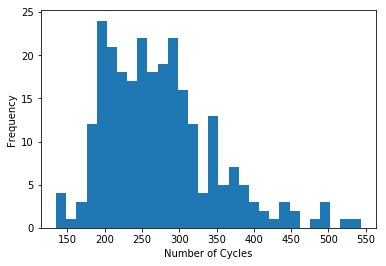

In [0]:
train_df.groupby(['Unit Number'])['Time (Cycles)'].max().hist(bins=30, grid=False)
plt.xlabel('Number of Cycles')
plt.ylabel('Frequency')
